In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
)
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
import pickle
warnings.filterwarnings("ignore")

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation(3)

## Scenarios to determine epsilon spacing

In [3]:
ScenResul = pd.read_csv('data\OpenScenRes.csv').drop(columns="Unnamed: 0")

In [4]:
ScenResul_mean =ScenResul.mean()

In [5]:
epsilon = []

## Reference Scenario for optimizer


In [6]:
#load it
with open("data\ScenariosOpenExplo", 'rb') as file2:
    Scenarios = pickle.load(file2)

In [7]:
for i in dike_model.outcomes:
    print(i)

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x000002252C68C860>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x000002252C68C860>)
ScalarOutcome('A.1_Expected Annual Damage', variable_name=('A.1_Expected Annual Damage',), function=<function sum_over at 0x000002252C68C860>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x000002252C68C860>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x000002252C68C860>)
ScalarOutcome('A.2_Expected Annual Damage', variable_name=('A.2_Expected Annual Damage',), function=<function sum_over at 0x000002252C68C860>)
ScalarOutcome('A.3 Total Costs', variable_name=('A.3_Expected Annual Damage', 'A.3_Dike Investme

## Optimizer

In [8]:
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress

# we need to store our results for each seed
results = []
convergences = []
n = 1

with MultiprocessingEvaluator(dike_model) as evaluator:
    # we run again for 5 seeds
    for i in range(n):
        # we create 2 covergence tracker metrics
        # the archive logger writes the archive to disk for every x nfe
        # the epsilon progress tracks during runtime
        convergence_metrics = [
            ArchiveLogger(
                r"./archives",
                [l.name for l in dike_model.levers],
                [o.name for o in dike_model.outcomes],
                base_filename=f"{i}.tar.gz",
            ),
            
            EpsilonProgress(),
        ]

        result, convergence = evaluator.optimize(
            nfe=10000,
            searchover="levers",
            epsilons=[0.1] * len(dike_model.outcomes),
            convergence=convergence_metrics,
            reference = Scenarios[0]
        )

        results.append(result)
        convergences.append(convergence)

16884it [1:32:58,  3.03it/s]                                                   


## Remove A.1 metrics, because result in an range error in standardise function of platypus

In [19]:
for i in range(len(results)):
    results[i].drop(columns=["A.1_Expected Number of Deaths","A.1_Expected Annual Damage"],inplace=True)

KeyError: "['A.1_Expected Number of Deaths', 'A.1_Expected Annual Damage'] not found in axis"

In [20]:
results

[      0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
 0           0        1        1        1        1        1        0        1   
 1           1        0        0        0        0        1        0        1   
 2           0        0        1        0        1        0        1        1   
 3           0        0        0        1        1        1        1        1   
 4           0        1        0        1        0        0        0        1   
 ...       ...      ...      ...      ...      ...      ...      ...      ...   
 5176        0        0        0        0        0        1        0        0   
 5177        0        0        0        0        0        0        0        1   
 5178        0        0        0        0        1        0        1        0   
 5179        0        0        1        0        1        0        0        0   
 5180        1        0        1        0        0        1        0        0   
 
       2_RfR 2  3_RfR 0  .

In [21]:
from optimization_tuned import epsilon_nondominated,HypervolumeMetric, Hypervolume

In [22]:
k = r"./archives"


## Remove which are not required

In [23]:
all_archives = []

for i in range(n):
    archives = ArchiveLogger.load_archives(k+ "\\" + f"{i}.tar.gz")
    for key in archives.keys():
        del archives[key]["Unnamed: 0"]
        del archives[key]["A.1_Expected Number of Deaths"]
        del archives[key]["A.1_Expected Annual Damage"]
        
    print(archives)
   
    all_archives.append(archives)

{0: Empty DataFrame
Columns: [0_RfR 0, 0_RfR 1, 0_RfR 2, 1_RfR 0, 1_RfR 1, 1_RfR 2, 2_RfR 0, 2_RfR 1, 2_RfR 2, 3_RfR 0, 3_RfR 1, 3_RfR 2, 4_RfR 0, 4_RfR 1, 4_RfR 2, EWS_DaysToThreat, A.1_DikeIncrease 0, A.1_DikeIncrease 1, A.1_DikeIncrease 2, A.2_DikeIncrease 0, A.2_DikeIncrease 1, A.2_DikeIncrease 2, A.3_DikeIncrease 0, A.3_DikeIncrease 1, A.3_DikeIncrease 2, A.4_DikeIncrease 0, A.4_DikeIncrease 1, A.4_DikeIncrease 2, A.5_DikeIncrease 0, A.5_DikeIncrease 1, A.5_DikeIncrease 2, A.1 Total Costs, A.2 Total Costs, A.2_Expected Number of Deaths, A.2_Expected Annual Damage, A.3 Total Costs, A.3_Expected Number of Deaths, A.3_Expected Annual Damage, A.4 Total Costs, A.4_Expected Number of Deaths, A.4_Expected Annual Damage, A.5 Total Costs, A.5_Expected Number of Deaths, A.5_Expected Annual Damage, RfR Total Costs, Expected Evacuation Costs]
Index: []

[0 rows x 46 columns], 100:     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         1        1        1      

In [24]:
print(all_archives)

[{0: Empty DataFrame
Columns: [0_RfR 0, 0_RfR 1, 0_RfR 2, 1_RfR 0, 1_RfR 1, 1_RfR 2, 2_RfR 0, 2_RfR 1, 2_RfR 2, 3_RfR 0, 3_RfR 1, 3_RfR 2, 4_RfR 0, 4_RfR 1, 4_RfR 2, EWS_DaysToThreat, A.1_DikeIncrease 0, A.1_DikeIncrease 1, A.1_DikeIncrease 2, A.2_DikeIncrease 0, A.2_DikeIncrease 1, A.2_DikeIncrease 2, A.3_DikeIncrease 0, A.3_DikeIncrease 1, A.3_DikeIncrease 2, A.4_DikeIncrease 0, A.4_DikeIncrease 1, A.4_DikeIncrease 2, A.5_DikeIncrease 0, A.5_DikeIncrease 1, A.5_DikeIncrease 2, A.1 Total Costs, A.2 Total Costs, A.2_Expected Number of Deaths, A.2_Expected Annual Damage, A.3 Total Costs, A.3_Expected Number of Deaths, A.3_Expected Annual Damage, A.4 Total Costs, A.4_Expected Number of Deaths, A.4_Expected Annual Damage, A.5 Total Costs, A.5_Expected Number of Deaths, A.5_Expected Annual Damage, RfR Total Costs, Expected Evacuation Costs]
Index: []

[0 rows x 46 columns], 100:     0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         1        1        1     

In [26]:
dike_model_problem =dike_model
dike_model_problem.outcomes.__delitem__("A.1_Expected Number of Deaths")
dike_model_problem.outcomes.__delitem__("A.1_Expected Annual Damage")


KeyError: 'A.1_Expected Number of Deaths'

## Calc metrics

In [27]:
from optimization_tuned import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem

problem = to_problem(dike_model_problem, searchover="levers")
print(results)

reference_set = epsilon_nondominated(results, [0.1] * (len(dike_model.outcomes)), problem)
print(reference_set)
# hv = HypervolumeMetric(reference_set, problem)
# print(1)
gd = GenerationalDistanceMetric(reference_set, problem, d=1)
print(2)
ei = EpsilonIndicatorMetric(reference_set, problem)
print(3)
ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
print(4)
sm = SpacingMetric(problem)
print(5)


metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        print(f'nfe: {nfe}')
        print(f'archive: {archive}')
        if int(nfe) == 0:
            continue
        scores = {
            "generational_distance": gd.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)

[      0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0           0        1        1        1        1        1        0        1   
1           1        0        0        0        0        1        0        1   
2           0        0        1        0        1        0        1        1   
3           0        0        0        1        1        1        1        1   
4           0        1        0        1        0        0        0        1   
...       ...      ...      ...      ...      ...      ...      ...      ...   
5176        0        0        0        0        0        1        0        0   
5177        0        0        0        0        0        0        0        1   
5178        0        0        0        0        1        0        1        0   
5179        0        0        1        0        1        0        0        0   
5180        1        0        1        0        0        1        0        0   

      2_RfR 2  3_RfR 0  ...  A.3_Expec

## Plot

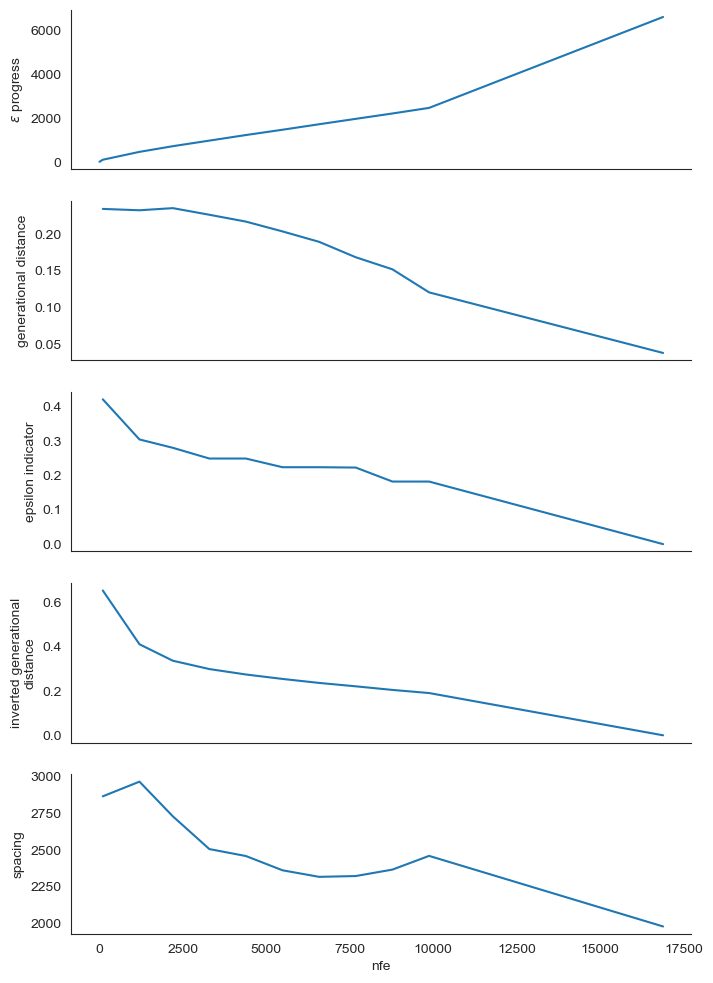

In [28]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=5, figsize=(8, 12), sharex=True)

ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    # ax1.plot(metrics.nfe, metrics.hypervolume)
    # ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")


sns.despine(fig)

plt.show()

In [29]:
print(metrics)

    generational_distance  epsilon_indicator   inverted_gd      spacing    nfe
0                0.233852       4.206140e-01  6.524730e-01  2862.365076    100
1                0.232019       3.040404e-01  4.101930e-01  2961.892309   1198
3                0.234911       2.797509e-01  3.359820e-01  2726.707499   2198
4                0.225910       2.486046e-01  2.984536e-01  2504.481903   3292
5                0.216621       2.485847e-01  2.739860e-01  2457.297017   4387
6                0.203283       2.233940e-01  2.539907e-01  2360.600872   5483
7                0.189095       2.233940e-01  2.359901e-01  2316.142298   6581
8                0.168174       2.224202e-01  2.207142e-01  2321.573289   7677
9                0.151759       1.817427e-01  2.044656e-01  2365.293624   8776
10               0.120449       1.817427e-01  1.904383e-01  2458.341630   9874
2                0.038103       2.220446e-16  2.585506e-15  1979.404619  16884
